## Setup

### Download dataset

In [1]:
from huggingface_hub import hf_hub_download

In [74]:
hf_hub_download(repo_id="hotamago/bkai-vietnamese-handwritten-ORC", filename="training_data.zip", local_dir="data", repo_type="dataset")
hf_hub_download(repo_id="hotamago/bkai-vietnamese-handwritten-ORC", filename="public_test_data.zip", local_dir="data", repo_type="dataset")
hf_hub_download(repo_id="hotamago/bkai-vietnamese-handwritten-ORC", filename="labels.txt", local_dir="data", repo_type="dataset")

'data/labels.txt'

### Import libraries

In [5]:
import tensorflow as tf
from common import *
import matplotlib.pyplot as plt
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    # RIP Training time
    raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

2023-09-20 08:50:32.600573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 08:50:32.622293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 08:50:32.622837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Extract zip

In [6]:
TRAIN_DATA_ZIP_PATH = "data/training_data.zip"

In [10]:
import zipfile
with zipfile.ZipFile(TRAIN_DATA_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("vietnamese_hcr/raw")

### Constants

In [11]:
import pathlib
# finding where we are so we dont need to type absolute path everytime
current_directory_path = pathlib.Path("./vietnamese_hcr").absolute()
current_directory_path

PosixPath('/root/Vietnamese-Handwritten-Text-Recognition/vietnamese_hcr')

In [13]:
import os
# path to our directory images

# our train and test folder (not used for now but used later when we want to save images after processing)
DATA_PATH = os.path.join(str(current_directory_path), "data")
TEST_FOLDER = os.path.join(DATA_PATH, "test")
TRAIN_FOLDER = os.path.join(DATA_PATH, "train")

# our raw folders
RAW_FOLDER = os.path.join(str(current_directory_path),"raw")
RAW_DATA_FOLDER = os.path.join(RAW_FOLDER,"new_train")

# label json files
LABEL_PATH = os.path.join(RAW_FOLDER, "labels.txt")

In [14]:
if not os.path.exists(TEST_FOLDER):
    os.makedirs(TEST_FOLDER)
if not os.path.exists(TRAIN_FOLDER):
    os.makedirs(TRAIN_FOLDER)

### Preprocessing labels

In [15]:
Label_data = []
# open these raw label files
with open(LABEL_PATH, 'r', encoding='utf8') as f:
    s = f.read()
    Label_data = s.split('\n')

In [16]:
for i in range(len(Label_data)):
    obj = Label_data[i].split('\t')
    Label_data[i] = {
        'name': obj[0],
        'text': obj[1]
    }

### Get info from data

In [17]:
max_label_len = 0

# find the maximum label length
for label in Label_data:
    max_label_len = max(len(label['text']), max_label_len)

max_label_len

17

In [18]:
# find all characters in labels (so we don't blindly add chacters not even existed in our dataset)
char_list = set()
for label in Label_data:
    char_list.update(set(label["text"]))
char_list = sorted(char_list)
len(char_list)

187

In [19]:
# show all possible labels characters
"".join(char_list)

'-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ'

In [ ]:
import numpy as np

# lists for training dataset
resize_max_width=0
i=0
for label in Label_data:
    train_img_path = os.path.join(RAW_DATA_FOLDER, label['name'])

    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(train_img_path), cv2.COLOR_BGR2GRAY)
    
    height, width = img.shape

    # in this dataset, we don't need to do any resize at all here.
    img = cv2.resize(img,(int(100/height*width), 100))
    
    height, width = img.shape
    
    if img.shape[1] > resize_max_width:
        resize_max_width = img.shape[1]

    i+=1
    if (i%500 == 0):
        print ("has processed trained {} files".format(i))

print(resize_max_width)

Max width image in training images is 766, so I set 800 for pertty :V
Max length label is 17, again I set 20 for pertty :V

### Testing

In [8]:
pad_listint(encodeText("hello"))

array([34, 31, 38, 38, 41, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

In [9]:
decodeText(pad_listint(encodeText("hello")))

'hello'

In [10]:
calCER("hello", "hallo")

1

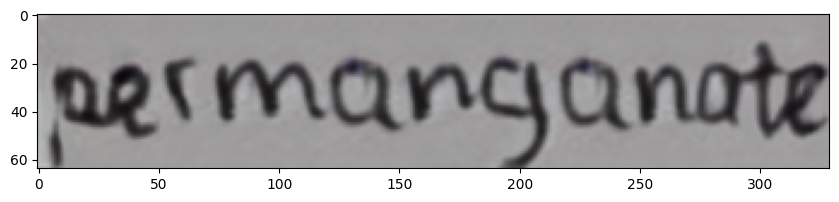

514


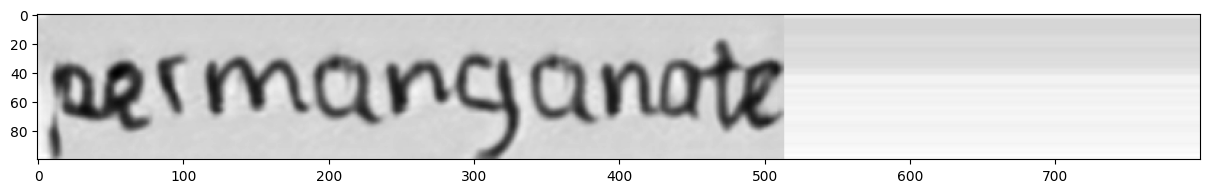

514


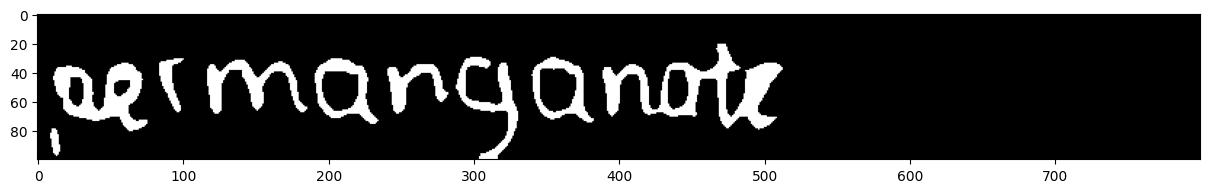

In [11]:
img = cv2.imread(os.path.join(RAW_DATA_FOLDER, Label_data[102987]['name']))
imgShow(img)

imgShow(autoResize(img, size = (800, 100)))

niceImage = orcPreprocess(img, default_fixed_size = (800, 100), default_filter_size = (5, 5))
imgShow(niceImage)

## Import

In [20]:
# BUILD THE PIPELINE FOR THE IMAGES, definitely this is super basic pipeline and can be improved
import numpy as np

## Constants

In [21]:
fixed_size = (800, 100)
fixed_length = 20

## Loading data

In [22]:
# being a good Data Scientist, we need to have train set and test set
from sklearn.model_selection import train_test_split
test_size = 0.2
train_label_data, val_label_data = train_test_split(Label_data, test_size=test_size, random_state=42)

In [23]:
# lists for training dataset
training_img = []
training_label = []

# Load images
i=0
for label in train_label_data:
    train_img_path = os.path.join(RAW_DATA_FOLDER, label['name'])

    # read input image and convert into gray scale image
    img = cv2.imread(train_img_path)
    
    # Process Image
    niceImage = orcPreprocess(img, default_fixed_size = fixed_size, default_filter_size = (5, 5))
    
    # Add labels
    training_img.append(niceImage)
    training_label.append(label['text'])

    i+=1
    if (i%500 == 0):
        print ("has processed trained {} files".format(i))

has processed trained 500 files
has processed trained 1000 files
has processed trained 1500 files
has processed trained 2000 files
has processed trained 2500 files
has processed trained 3000 files
has processed trained 3500 files
has processed trained 4000 files
has processed trained 4500 files
has processed trained 5000 files
has processed trained 5500 files
has processed trained 6000 files
has processed trained 6500 files
has processed trained 7000 files
has processed trained 7500 files
has processed trained 8000 files
has processed trained 8500 files
has processed trained 9000 files
has processed trained 9500 files
has processed trained 10000 files
has processed trained 10500 files
has processed trained 11000 files
has processed trained 11500 files
has processed trained 12000 files
has processed trained 12500 files
has processed trained 13000 files
has processed trained 13500 files
has processed trained 14000 files
has processed trained 14500 files
has processed trained 15000 files


In [24]:
#lists for validation dataset
valid_img = []
valid_label = []

# Load images
i=0
for label in val_label_data:
    train_img_path = os.path.join(RAW_DATA_FOLDER, label['name'])

    # read input image and convert into gray scale image
    img = cv2.imread(train_img_path)
    
    # Process Image
    niceImage = orcPreprocess(img, default_fixed_size = fixed_size, default_filter_size = (5, 5))
    
    # Add labels
    valid_img.append(niceImage)
    valid_label.append(label['text'])

    i+=1
    if (i%500 == 0):
        print ("has processed trained {} files".format(i))

has processed trained 500 files
has processed trained 1000 files
has processed trained 1500 files
has processed trained 2000 files
has processed trained 2500 files
has processed trained 3000 files
has processed trained 3500 files
has processed trained 4000 files
has processed trained 4500 files
has processed trained 5000 files
has processed trained 5500 files
has processed trained 6000 files
has processed trained 6500 files
has processed trained 7000 files
has processed trained 7500 files
has processed trained 8000 files
has processed trained 8500 files
has processed trained 9000 files
has processed trained 9500 files
has processed trained 10000 files
has processed trained 10500 files
has processed trained 11000 files
has processed trained 11500 files
has processed trained 12000 files
has processed trained 12500 files
has processed trained 13000 files
has processed trained 13500 files
has processed trained 14000 files
has processed trained 14500 files
has processed trained 15000 files


## Build model

In [25]:
# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [26]:
# OUR FULL MODEL OF CRNN AND LSTM

# input with shape of height=100 and width=800 
inputs = Input(shape=(fixed_size[1],fixed_size[0],1))
 
# Block 1
x = Conv2D(64, (3,3), padding='same')(inputs)
x = MaxPool2D(pool_size=3, strides=3)(x)
x = Activation('relu')(x)
x_1 = x 

# Block 2
x = Conv2D(128, (3,3), padding='same')(x)
x = MaxPool2D(pool_size=3, strides=3)(x)
x = Activation('relu')(x)
x_2 = x

# Block 3
x = Conv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_3 = x

# Block4
x = Conv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x,x_3])
x = Activation('relu')(x)
x_4 = x

# Block5
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_5 = x

# Block6
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x,x_5])
x = Activation('relu')(x)

# Block7
x = Conv2D(1024, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 1))(x)
x = Activation('relu')(x)

# pooling layer with kernel size (2,2) to make the height/2 #(1,9,512)
x = MaxPool2D(pool_size=(3, 1))(x)
 
# # to remove the first dimension of one: (1, 31, 512) to (31, 512) 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(x)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time

act_model = Model(inputs, outputs)

2023-09-20 08:55:00.098303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 08:55:00.098632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 08:55:00.098825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [27]:
act_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 800, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 800, 64)         640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 33, 266, 64)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 activation (Activation)     (None, 33, 266, 64)          0         ['max_pooling2d[0][0]']   

In [28]:
### ctc definition part 
"""
The reason why we use ctc_batch_cost instead of ctc_cost because
In batch cost, the program managed to mask out padded sequence using label_length, 
So the cost won't include the padding 0 section.
"""

"""
The way CTC is modelled currently in Keras is that you need to implement the loss function as a layer, you did that already (loss_out). 
Your problem is that the inputs you give that layer are not tensors from Theano/TensorFlow but numpy arrays.
To change that one option is to model these values as inputs to your model.
That is why we need to manually create Input for labels, input length and label_length.
"""

# define the label input shape for ctc
labels = Input(name='the_labels', shape=[fixed_length], dtype='float32')

"""
where input_length and label_length are constants you created previously
the easiest way here is to have a fixed batch size in training 
the lengths should have the same batch size (see shapes in the link for ctc_cost)   
"""

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
# define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [29]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath=os.path.join('checkpoint_weights.hdf5'),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=20,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 800, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 800, 64)         640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 33, 266, 64)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 activation (Activation)     (None, 33, 266, 64)          0         ['max_pooling2d[0][0]'] 

In [31]:
train_input_length = []
train_label_length = []
for label in training_label:
    train_input_length.append(fixed_length)
    train_label_length.append(len(label))

valid_input_length = []
valid_label_length = []
for label in valid_label:
    valid_input_length.append(fixed_length)
    valid_label_length.append(len(label))

In [32]:
train_padded_txt = []
for label in training_label:
    train_padded_txt.append(pad_listint(encodeText(label)) + 1)

valid_padded_txt = []
for label in valid_label:
    valid_padded_txt.append(pad_listint(encodeText(label)) + 1)

In [33]:
train_padded_txt = np.array(train_padded_txt)
valid_padded_txt = np.array(valid_padded_txt)

In [34]:
# notice I convert everything to numpy array here since model can fit either tensors and numpy array
# the reason why i stick with numpy array because it is simple to code and also because it is baseline solution
# I want to use openCV (can't run with tensors because it is CPU operations)
# And if I want to use tensors then i will make sure my image preprocessing functions uses tensor compatible operations

# ready our training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  # all must be equal length to T timesteps
train_label_length = np.array(train_label_length)  # different length (only the same in Captcha dataset)

# ready our validating data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

In [35]:
print(training_img.shape, train_padded_txt.shape, train_input_length.shape, train_label_length.shape)
print(valid_img.shape, valid_padded_txt.shape, valid_input_length.shape, valid_label_length.shape)

(82400, 100, 800) (82400, 20) (82400,) (82400,)
(20600, 100, 800) (20600, 20) (20600,) (20600,)


In [36]:
# choose batchsize and epochs

batch_size = 32
epochs = 100

history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callbacks_list)

2023-09-20 08:55:12.915220: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6592000000 exceeds 10% of free system memory.
2023-09-20 08:55:17.228952: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6592000000 exceeds 10% of free system memory.


Epoch 1/100


2023-09-20 08:55:30.121575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-20 08:55:33.086648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-20 08:55:33.526002: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15e36a9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-20 08:55:33.526055: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-09-20 08:55:33.559628: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-20 08:55:33.878141: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proc

2575/2575 [==============================] - ETA: 0s - loss: 11.8553

2023-09-20 08:58:44.974964: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1648000000 exceeds 10% of free system memory.
2023-09-20 08:58:45.946798: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1648000000 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 7.42994, saving model to checkpoint_weights.hdf5
2575/2575 [==============================] - 230s 82ms/step - loss: 11.8553 - val_loss: 7.4299 - lr: 0.0010
Epoch 2/100
2575/2575 [==============================] - ETA: 0s - loss: 5.0070
Epoch 2: val_loss improved from 7.42994 to 3.97494, saving model to checkpoint_weights.hdf5
2575/2575 [==============================] - 203s 79ms/step - loss: 5.0070 - val_loss: 3.9749 - lr: 0.0010
Epoch 3/100
2575/2575 [==============================] - ETA: 0s - loss: 3.1398
Epoch 3: val_loss improved from 3.97494 to 2.87562, saving model to checkpoint_weights.hdf5
2575/2575 [==============================] - 204s 79ms/step - loss: 3.1398 - val_loss: 2.8756 - lr: 0.0010
Epoch 4/100
2575/2575 [==============================] - ETA: 0s - loss: 2.3524
Epoch 4: val_loss improved from 2.87562 to 2.55322, saving model to checkpoint_weights.hdf5
2575/2575 [==============================] - 203s 79ms/step - loss: 2.352

KeyboardInterrupt: 

## Saved model

In [ ]:
act_model.save_weights(os.path.join('pretrained', 'checkpoint_weights.hdf5'))

## Evalution

In [38]:
# load the saved best model weights
act_model.load_weights('checkpoint_weights.hdf5')

In [39]:
# predict outputs on validation images
NO_PREDICTS = 100
OFFSET=0
# prediction = act_model.predict(valid_img[OFFSET:OFFSET+NO_PREDICTS])
prediction = act_model.predict(valid_img)

2023-09-20 09:36:58.463878: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1648000000 exceeds 10% of free system memory.


644/644 [==============================] - 17s 22ms/step


In [40]:
# NO_PREDICTS image results
# 9 timesteps
# 32 chars + 1 blank
prediction.shape

(20600, 88, 188)

In [61]:
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
# see the results
all_predictions =[]
i = 0
for x in out:
    print("original_text  = ", valid_label[i+OFFSET])
    print("predicted text = ", end = '')
    pred = decodeText(x-1)
    print(pred)
    all_predictions.append(pred)
    i+=1

original_text  =  phải
predicted text = phải
original_text  =  tiếp
predicted text = tiếp
original_text  =  nốc-ao
predicted text = nốc-a
original_text  =  đít-cua
predicted text = đít-cua
original_text  =  Phương
predicted text = thường
original_text  =  hiều
predicted text = hiều
original_text  =  VAGÔNG
predicted text = VAGÔNG
original_text  =  So
predicted text = So
original_text  =  không
predicted text = khõng
original_text  =  cán
predicted text = cán
original_text  =  kinh
predicted text = kinh
original_text  =  Chỉ
predicted text = Chỉ
original_text  =  XTƠ-RẾT
predicted text = TƠ-RẾT
original_text  =  PÀNG
predicted text = ĐÀNG
original_text  =  GÀN
predicted text = GÀN
original_text  =  RỦA
predicted text = RỦA
original_text  =  GƯỞI
predicted text = GƯỞI
original_text  =  TRƠI
predicted text = TRỞI
original_text  =  Le-Va
predicted text = Le-Va
original_text  =  Vector
predicted text = Vector
original_text  =  XHCN
predicted text = XHCN
original_text  =  tăng
predicted text

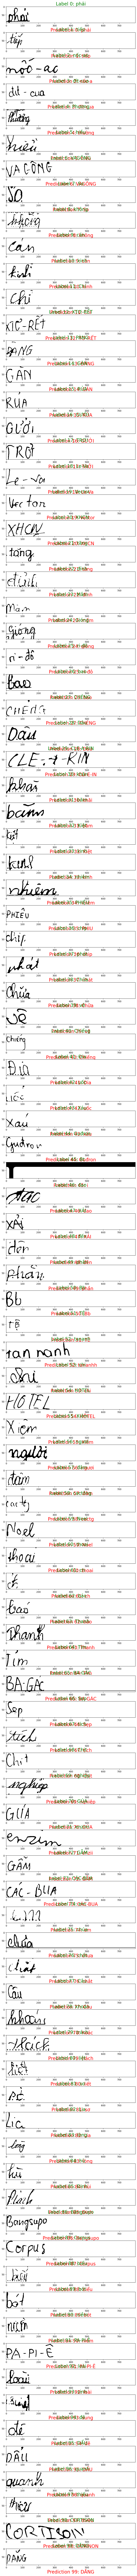

In [62]:
#YOUR PART: WRITE TO PRINT OUT THE IMAGES IN NICE 2D ARRAY PLOT WITH ORIGINAL TEXT AND PREDICTED TEXT 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10,200))
col=0
row=1
gs1 = gridspec.GridSpec(NO_PREDICTS, 1)
# gs1.update(wspace=0.025, hspace=0.025)
for n in range(NO_PREDICTS):
    plt.subplot(gs1[n])
    plt.imshow(valid_img[n][:,:], cmap="gray_r")
    plt.title(f"Label {n}: "+valid_label[n+OFFSET], fontsize=20, color="green")
    plt.xlabel(f"Prediction {n}: "+all_predictions[n+OFFSET], fontsize=20, color="red")


In [70]:
import string

def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1)

    cer = []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = calCER(pd_cer, gt_cer)
        cer.append(dist)

    cer_f = sum(cer) / len(cer)
    
    return (cer_f)

In [72]:
evaluate = ocr_metrics(predicts=all_predictions,
                                  ground_truth=valid_label,
                                  norm_accentuation=False,
                                  norm_punctuation=False)

e_corpus = "\n".join([
    "Metrics:",
    "CER: {}".format(evaluate),
])

In [73]:
print(e_corpus)

Metrics:
CER: 0.4367961165048544


## Run public test

In [75]:
TRAIN_DATA_ZIP_PATH = "data/public_test_data.zip"

In [76]:
import zipfile
with zipfile.ZipFile(TRAIN_DATA_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("vietnamese_hcr/public_test")

In [77]:
import os

def list_files(dir_path):
    # list to store files
    res = []
    try:
        for file_path in os.listdir(dir_path):
            if os.path.isfile(os.path.join(dir_path, file_path)):
                res.append(file_path)
    except FileNotFoundError:
        print(f"The directory {dir_path} does not exist")
    except PermissionError:
        print(f"Permission denied to access the directory {dir_path}")
    except OSError as e:
        print(f"An OS error occurred: {e}")
    return res

In [78]:
files = list_files(os.path.join("vietnamese_hcr", "public_test", "new_public_test"))

In [84]:
#lists for validation dataset
public_img = []

# Load images
i=0
for img_path in files:
    # read input image and convert into gray scale image
    img = cv2.imread((os.path.join("vietnamese_hcr", "public_test", "new_public_test", img_path)))
    
    # Process Image
    niceImage = orcPreprocess(img, default_fixed_size = fixed_size, default_filter_size = (5, 5))
    
    # Add labels
    public_img.append(niceImage)

    i+=1
    if (i%500 == 0):
        print ("has processed {} files".format(i))

has processed 500 files
has processed 1000 files
has processed 1500 files
has processed 2000 files
has processed 2500 files
has processed 3000 files
has processed 3500 files
has processed 4000 files
has processed 4500 files
has processed 5000 files
has processed 5500 files
has processed 6000 files
has processed 6500 files
has processed 7000 files
has processed 7500 files
has processed 8000 files
has processed 8500 files
has processed 9000 files
has processed 9500 files
has processed 10000 files
has processed 10500 files
has processed 11000 files
has processed 11500 files
has processed 12000 files
has processed 12500 files
has processed 13000 files
has processed 13500 files
has processed 14000 files
has processed 14500 files
has processed 15000 files
has processed 15500 files
has processed 16000 files
has processed 16500 files
has processed 17000 files
has processed 17500 files
has processed 18000 files
has processed 18500 files
has processed 19000 files
has processed 19500 files
has pr

In [86]:
public_img = np.array(public_img)

In [88]:
# prediction = act_model.predict(valid_img[OFFSET:OFFSET+NO_PREDICTS])
prediction = act_model.predict(public_img)

1032/1032 [==============================] - 23s 23ms/step


In [91]:
prediction.shape

(33000, 88, 188)

In [92]:
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
# see the results
all_predictions =[]
i = 0
for x in out:
    pred = decodeText(x-1)
    all_predictions.append(pred)
    i+=1

In [93]:
len(all_predictions)

33000

## Write to file

In [94]:
with open('prediction.txt', 'w') as f:
    for i in range(len(files)):
        f.write("{0} {1}\n".format(files[i], all_predictions[i]))